# Practice Session 5: Hypothesis Testing II

In [241]:
import pandas as pd
import numpy as np

import seaborn as sns

from scipy import stats
from scipy.stats import ttest_1samp, ttest_ind, ttest_rel, f, shapiro, levene

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 8)

import plotly.graph_objs as go
import ipywidgets as widgets
from ipywidgets import HBox, VBox, Layout
from IPython.display import display


import warnings
warnings.filterwarnings('ignore')

## Part 1: Revisiting and Continuing the *t*-Test

#### <font color="#fc7202">Task 1:</font>

You are interested in methane emissions from cows, an important contributor to [global greenhouse gas forcing](https://physicsworld.com/a/battling-bovine-belching-measuring-methane-emissions-from-cows/).  
You collected **10 intestinal gas samples** from different cows near Örebro. You analyzed each sample once, and then asked a friend to analyze the **same** samples independently.

**Part 1**

Your results and your friend’s results are listed below, as concentration of methane in the intestinal gas in units of parts per thousand (ppt).
<div style="display: flex; align-items: center; justify-content: space-between;">

<div style="flex: 1;">

| Sample | Your result | Friend’s result |
|:-----:|------------:|----------------:|
| 1 | 84.63 | 83.15 |
| 2 | 24.38 | 23.72 |
| 3 | 14.08 | 13.84 |
| 4 | 104.41 | 104.20 |
| 5 | 73.82 | 73.92 |
| 6 | 33.55 | 34.16 |
| 7 | 93.92 | 94.02 |
| 8 | 23.69 | 23.60 |
| 9 | 4.06 | 4.13 |
|10 | 84.03 | 84.24 |
</div>

<div style="flex: 30 0 400px; margin-left: 40px;">
<img src="https://raw.githubusercontent.com/RaHub4AI/MI7032/refs/heads/main/Pictures/cool_cow.png"
     alt="Curious cow"
     width="400"
     style="border-radius: 10px;">
</div>

</div>

Is there a **significant difference** between your results and your friend’s results?



- **Null hypothesis ($H_0$):**  
  On average, your method and your friend’s method give the same methane concentration.\
  <font color='#00bf63'>*$H_0\!:\,\mu_{mine} = \mu_{friend}$*</font>

- **Alternative hypothesis ($H_1$):**  
  On average, the methods give different concentrations.\
  <font color='#00bf63'>*$H_1\!:\,\mu_{mine} \neq \mu_{friend}$*</font> 

In [3]:
cow_df = pd.DataFrame({'sample_id': np.arange(1, 11),
                      'me': [84.63, 24.38, 14.08, 104.41, 73.82, 33.55, 93.92, 23.69, 4.06, 84.03],
                      'friend': [83.15, 23.72, 13.84, 104.20, 73.92, 34.16, 94.02, 23.60, 4.13, 84.24]})

cow_df

,sample_id,me,friend
0,1,84.63,83.15
1,2,24.38,23.72
2,3,14.08,13.84
3,4,104.41,104.20
4,5,73.82,73.92
5,6,33.55,34.16
6,7,93.92,94.02
7,8,23.69,23.60
8,9,4.06,4.13
9,10,84.03,84.24


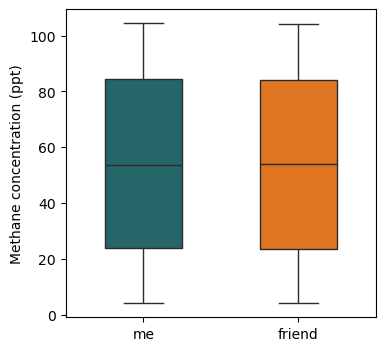

In [17]:
# Visualizing methane measurements: my results vs. friend's

# Convertind dataframe to long format for easier plotting
cow_df_long = cow_df.melt(id_vars='sample_id',
                          value_vars=['me', 'friend'],
                          var_name='person',
                          value_name='methane_ppt')

# Boxplot comparison
fig, ax = plt.subplots(figsize=(4, 4))
sns.boxplot(data=cow_df_long, x='person', y='methane_ppt', palette=['#1b7173', '#fc7202'], width=0.5, ax=ax)
plt.xlabel('')
plt.ylabel('Methane concentration (ppt)')
plt.show()

> In this experiment, both you and your friend measured the same 10 cow samples.\
> That means each pair of measurements is linked - they come from the same physical sample, not from two independent groups.\
> Because of this dependency, we shouldn’t use an independent *t*-test (which assumes samples are unrelated).\
> Instead, we compare the differences within each pair: $d_i = c_{\text{mine},\,i} - c_{\text{friend},\,i}$\
> If the two methods agree on average, these differences should fluctuate around zero.\
> The paired *t*-test (also called the dependent samples *t*-test) checks exactly that - whether the mean of these paired differences is statistically different from zero.
> We can perform the paired *t*-test with `scipy.stats.ttest_rel()`:

In [20]:
t_stat, p_val = stats.ttest_rel(cow_df.me, cow_df.friend)
print(f't-statistic: {t_stat:.4f}, p-value: {p_val:.4f}')

t-statistic: 0.8821, p-value: 0.4007


> Since the *p*-value (0.4007) > 0.05, we fail to reject the null hypothesis.
> This means there is no statistically significant difference between your results and your friend’s results.

As already mentioned, the **paired *t*-test** essentially checks the **differences** between the two related measurements.  
In other words, instead of comparing two columns directly, we could just compute the differences: $d_i = c_{\text{mine},\,i} - c_{\text{friend},\,i}$
and then test whether the **mean of these differences** is significantly different from zero.

That’s exactly what the paired two-sample *t*-test does internally - it’s equivalent to performing a **one-sample *t*-test** on the difference values.

- **Null hypothesis ($H_0$)**: the average difference is zero  
  <font color='#00bf63'>*$H_0: \mu_d = 0$*</font>  
- **Alternative hypothesis ($H_1$)**: the average difference is not zero  
  <font color='#00bf63'>*$H_1: \mu_d \neq 0$*</font>


In [ ]:
# Calculating the paired differences (my result minus friend's result)
cow_df['difference'] = cow_df.me - cow_df.friend

> Before performing a *t*-test, we should check whether the **differences** are approximately **normally distributed**.  
> We’ll visualize with a **boxplot**, **histogram**, and **Q–Q plot**, and run the **Shapiro–Wilk test**:
> - If the Shapiro–Wilk *p*-value > 0.05 and the Q–Q plot looks roughly linear, the normality assumption is reasonable.

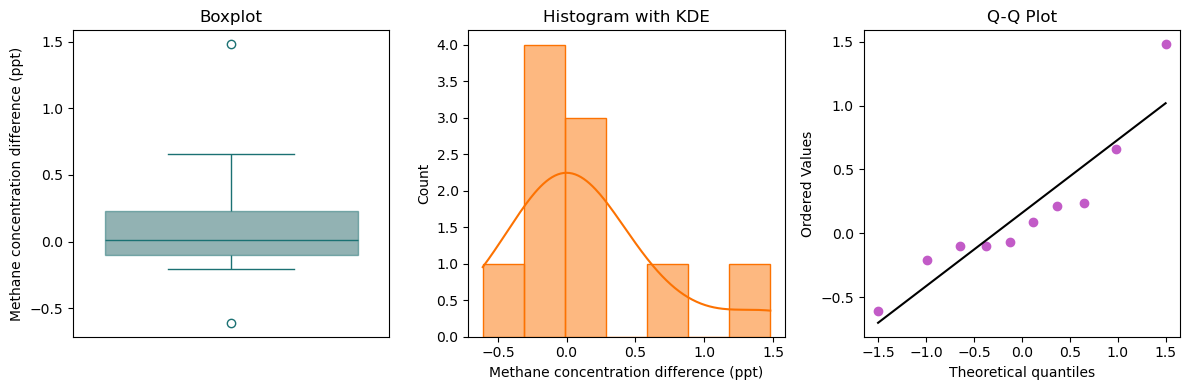

In [24]:
# Visualizing the experimental data using boxplot, histogram with KDE, and Q-Q plot
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

sns.boxplot(cow_df.difference, linecolor='#1b7173', color='#1b7173',  boxprops=dict(alpha=.5), ax=axes[0])
axes[0].set_xticks([])
axes[0].set_ylabel('Methane concentration difference (ppt)')
axes[0].set_title('Boxplot')

sns.histplot(cow_df.difference, kde=True, color='#fc7202', edgecolor='#fc7202', ax=axes[1])
axes[1].set_xlabel('Methane concentration difference (ppt)')
axes[1].set_ylabel('Count')
axes[1].set_title('Histogram with KDE')

stats.probplot(cow_df.difference, dist="norm", plot=axes[2])
axes[2].get_lines()[0].set_markerfacecolor('#c25bc7')   # color of the points
axes[2].get_lines()[0].set_markeredgecolor('#c25bc7')
axes[2].get_lines()[1].set_color('black')             # color of the reference line
axes[2].set_title("Q-Q Plot")
plt.tight_layout()

In [25]:
# Checking the normality assumption using the Shapiro–Wilk test
# Null hypothesis (H0): the data come from a normal distribution
statistic_SW, p_value_SW = stats.shapiro(cow_df.difference)
print(f'Shapiro-Wilk test statistic: {statistic_SW:.4f}, p-value: {p_value_SW:.4f}')

Shapiro-Wilk test statistic: 0.8784, p-value: 0.1250


> Even though the plots indicate that the data are not perfectly normally distributed (and we only have 10 data points), the Shapiro–Wilk test gives a *p*-value of 0.1250.\
> With *α*=0.05, we fail to reject the null hypothesis of normality.\
> Therefore, we proceed under the assumption of approximate normality and perform a two-tailed one-sample *t*-test on the differences.

In [26]:
t_stat_diff, p_val_diff = ttest_1samp(cow_df.difference, popmean=0 ,alternative='two-sided')
print(f't-statistic: {t_stat_diff:.4f}, p-value: {p_val_diff:.4f}')

t-statistic: 0.8821, p-value: 0.4007


> Notice that these values are **identical to the results obtained earlier** with `ttest_rel()`.  
> That’s because the **paired *t*-test** is indeed mathematically equivalent to performing a **one-sample *t*-test** on the **difference values** -\
> both test whether the mean difference between the two methods is zero.

**Part 2**

You suspect that your friend might not have been very careful when analyzing the intestinal gas samples for methane.
So you ask your friend to repeat the analysis of Sample 8 several times, while you also measure the same sample multiple times.
You complete the analysis 8 times, but your friend gets bored and stops after 5 repeated measurements.
The results are:

**Repeat measurements for Sample 8 (ppt):**

| Trial | Your results | Friend’s results |
|:----:|-------------:|-----------------:|
| 1 | 23.69 | 23.60 |
| 2 | 23.56 | 23.30 |
| 3 | 23.47 | 23.78 |
| 4 | 23.71 | 23.23 |
| 5 | 23.54 | 23.90 |
| 6 | 23.70 | - |
| 7 | 23.65 | - |
| 8 | 23.59 | - |

Are **your** methane measurements **significantly more precise** than your friend’s?

<font color='#00bf63'>*Your hypotheses here!*</font>

In [ ]:
# YOUR CODE HERE!

<font color='#00bf63'>*Your answer here!*</font>

In [28]:
repeated_measurements = pd.DataFrame({'trial': np.arange(1, 9),
                                      'me': [23.69, 23.56, 23.47, 23.71, 23.54, 23.70, 23.65, 23.59],
                                      'friend': [23.60, 23.30, 23.78, 23.23, 23.90, np.nan, np.nan, np.nan]})
repeated_measurements

,trial,me,friend
0,1,23.69,23.60
1,2,23.56,23.30
2,3,23.47,23.78
3,4,23.71,23.23
4,5,23.54,23.90
5,6,23.70,NaN
6,7,23.65,NaN
7,8,23.59,NaN


In [29]:
repeated_measurements.describe()

,trial,me,friend
count,8.00000,8.000000,5.000000
mean,4.50000,23.613750,23.562000
std,2.44949,0.087331,0.292438
min,1.00000,23.470000,23.230000
25%,2.75000,23.555000,23.300000
50%,4.50000,23.620000,23.600000
75%,6.25000,23.692500,23.780000
max,8.00000,23.710000,23.900000


> When we look at the data, the **means** of the two datasets are very close - both you and your friend obtained similar methane concentrations.  
> However, your results show a **standard deviation that is more than three times smaller** than your friend’s!
>
> Precision is about **how consistent** repeated measurements are, not how close they are to the true value.  
> A smaller standard deviation means **higher precision**.
>
> ![accuracy_precision](https://raw.githubusercontent.com/RaHub4AI/MI7032/refs/heads/main/Pictures/accuracy_precision.png)
> 
> Comparing **variances (or standard deviations)** between two datasets is done using the ***F*-test**.  
> The *F*-test (explained below) checks whether two variances differ significantly - that is, whether one set of measurements is statistically more precise than the other.
>
> Since the question specifically suggests that **your measurements might be more precise**, we should use a **one-tailed version** of the test (testing whether your variance is **smaller** than your friend’s).

- **Null hypothesis ($H_0$)**:\
  There is **no difference in precision** between your measurements and your friend’s - both populations have equal variances\
  <font color='#00bf63'>*$H_0: \sigma_{\text{yours}}^2 = \sigma_{\text{friend}}^2$*</font>  
- **Alternative hypothesis ($H_1$)**:\ 
  Your measurements are **more precise**, meaning your variance is **smaller** than your friend’s\
  <font color='#00bf63'>*$H_1: \sigma_{\text{yours}}^2 < \sigma_{\text{friend}}^2$*</font>

In [91]:
persons = ['me', 'friend']
for i, person in enumerate(persons):
    print(i, person)

0 me
1 friend


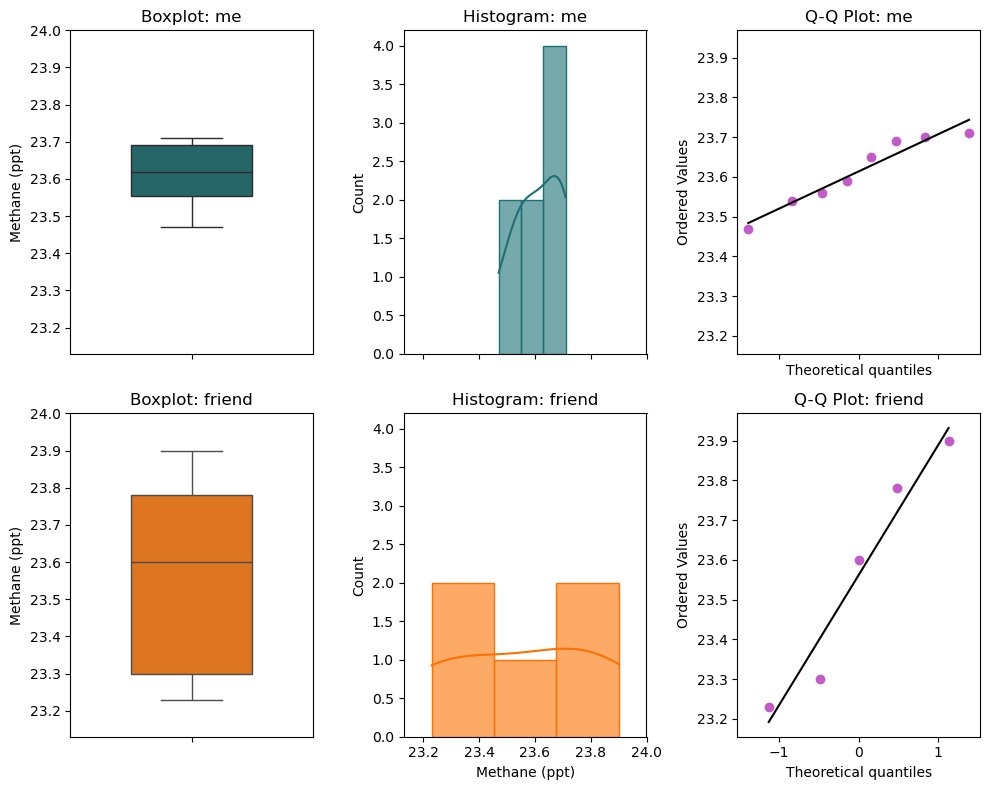

In [109]:
colors = ['#1b7173', '#fc7202']

# Set common axis limits for both samples to allow direct comparison
# For boxplots
y_min = min(repeated_measurements.me.min(), repeated_measurements.friend.dropna().min())
y_max = max(repeated_measurements.me.max(), repeated_measurements.friend.dropna().max())
# For histograms
x_min, x_max = y_min, y_max

fig, axes = plt.subplots(2, 3, figsize=(10, 8), sharex='col', sharey='col')

persons = ['me', 'friend']

# Enumerate() lets us loop through the list while also keeping track of the index (i)
# So i = 0, person = 'me'; i = 1, person = 'friend'
for i, person in enumerate(persons):
    sns.boxplot(y=repeated_measurements[person].dropna(), color=colors[i], width=0.5, ax=axes[i, 0])
    axes[i, 0].set_ylim(y_min - 0.1, y_max + 0.1)
    axes[i, 0].set_title(f'Boxplot: {person}')
    axes[i, 0].set_ylabel('Methane (ppt)')
    axes[i, 0].set_xlabel('')
    

    sns.histplot(repeated_measurements[person].dropna(), bins=3, kde=True, color=colors[i], alpha=0.6, edgecolor=colors[i], ax=axes[i, 1])
    axes[i, 1].set_xlim(x_min - 0.1, x_max + 0.1)
    axes[i, 1].set_title(f'Histogram: {person}')
    axes[i, 1].set_ylabel('Count')
    axes[i, 1].set_xlabel('Methane (ppt)')

    # Q–Q Plot
    stats.probplot(repeated_measurements[person].dropna(), dist='norm', plot=axes[i, 2])
    axes[i, 2].get_lines()[0].set_markerfacecolor('#c25bc7')
    axes[i, 2].get_lines()[0].set_markeredgecolor('#c25bc7')
    axes[i, 2].get_lines()[1].set_color('black')
    axes[i, 2].set_title(f'Q-Q Plot: {person}')

plt.tight_layout()
plt.show()


In [110]:
# Checking the normality assumption using the Shapiro–Wilk test
# Null hypothesis (H0): the data come from a normal distribution
sw_stat_me, sw_p_me = shapiro(repeated_measurements.me, nan_policy='omit') # 'nan_policy="omit"' ensures that any missing values are ignored instead of causing an error
sw_stat_friend, sw_p_friend = shapiro(repeated_measurements.friend, nan_policy='omit')

print('Shapiro–Wilk Test Results:')
print(f'Your measurements: test statistic: {sw_stat_me:.4f}, p-value: {sw_p_me:.4f}')
print(f"Friend's measurements: test statistic: {sw_stat_friend:.4f}, p-value: {sw_p_friend:.4f}")

Shapiro–Wilk Test Results:
Your measurements: test statistic: 0.9229, p-value: 0.4542
Friend's measurements: test statistic: 0.9206, p-value: 0.5335


> Both datasets yield *p*-values well above 0.05 (yours: 0.4542; friend’s: 0.5335).  
> Therefore, we **fail to reject the null hypothesis** that the data come from a normal distribution.  
> In other words, there is **no evidence of non-normality**, and we can reasonably assume that both datasets are approximately normally distributed,\
> which means the *F*-test can be applied.


<font color='#fc7202'>**In Python, there is no direct built-in function for the classical *F*-test for equality of two variances.**</font>
> *That is, for example `scipy.stats` does not currently provide a function like `stats.f_test()` or `stats.var_equal_test()` to directly compare two variances.*

However, you can very easily compute it manually using the *F*-distribution functions that SciPy does provide.
> *For reference, you can explore how the F-test is implemented in R’s source code: https://svn.r-project.org/R/tags/R-2-3-1/src/library/stats/R/var.test.R*

In [243]:
# Let's define our own F-test function
def f_test(sample1, sample2, alternative='two-sided'):
    sample1 = sample1.dropna().to_numpy()
    sample2 = sample2.dropna().to_numpy()
    variance_sample1 = np.var(sample1, ddof=1)
    variance_sample2 = np.var(sample2, ddof=1)
    df_sample1 = len(sample1) - 1
    df_sample2 = len(sample2) - 1
    
    F_statistic = variance_sample1/variance_sample2
    p_value = f.cdf(F_statistic, df_sample1, df_sample2)

    if alternative == 'greater':
        # H1: variance of sample1 > variance of sample2
        p_value = 1 - p_value
    elif alternative == 'less':
        # H1: variance of sample1 < variance of sample2
        p_value = p_value
    elif alternative == 'two-sided':
        # Two-tailed test: multiply the smaller tail probability by 2
        p_value = 2 * min(p_value, 1 - p_value)
    else:
        raise ValueError("alternative must be 'two-sided', 'greater', or 'less'.")

    return F_statistic, p_value

In [154]:
# Applying our defined function
f_statistic, p_value = f_test(repeated_measurements.me, repeated_measurements.friend, alternative='less')
print(f'F-statistic: {f_statistic:.4f}, p-value: {p_value:.4f}')

F-statistic: 0.0892, p-value: 0.0036


> The computed F-statistic is **0.0892**, with a corresponding *p*-value of **0.0036**.  
> Since the *p*-value is well below the significance level (α = 0.05), we **reject the null hypothesis** that the two variances are equal.  
>
> This means there is **strong evidence that the variances differ**, and given that the *F*-statistic is less than 1 (≈ 0.09), we conclude that **your measurements are significantly more precise** (i.e., have a smaller variance) than your friend’s.
>
> To better understand this result, we can also **visualize the *F*-test** using the helper function `plot_f_test()` below.  
> It shows the *F*-distribution together with the **critical region** and the **observed F-statistic**, making it easier to see why we reject the null hypothesis in this case.


In [160]:
def plot_f_test(F_obs, df1, df2, alpha=0.05, alternative='greater', curve_color="#00bf63", obs_color="#c25bc7"):

    x = np.linspace(0, 12, 800)
    y = f.pdf(x, df1, df2)

    plt.figure(figsize=(10, 4))
    plt.plot(x, y, color=curve_color, lw=2, label=f'F-distribution (df1={df1}, df2={df2})')

    if alternative == 'greater':
        # Right-tail critical value
        crit = f.ppf(1 - alpha, df1, df2)
        plt.fill_between(x, y, where=(x >= crit), alpha=0.35, color=curve_color, label=f'Rejection region (α={alpha}, right tail)')
        plt.axvline(crit, color='black', ls='--', lw=1, label=f'Critical F = {crit:.2f}')

    elif alternative == 'less':
        # Left-tail critical value
        crit = f.ppf(alpha, df1, df2)
        plt.fill_between(x, y, where=(x <= crit), alpha=0.35, color=curve_color, label=f'Rejection region (α={alpha}, left tail)')
        plt.axvline(crit, color='black', ls='--', lw=1, label=f'Critical F = {crit:.2f}')

    elif alternative == 'two-sided':
        # Two tails
        crit_low  = f.ppf(alpha/2, df1, df2)
        crit_high = f.ppf(1 - alpha/2, df1, df2)
        plt.fill_between(x, y, where=(x <= crit_low),  alpha=0.35, color=curve_color)
        plt.fill_between(x, y, where=(x >= crit_high), alpha=0.35, color=curve_color, label=f'Rejection regions (α={alpha}, two-sided)')
        plt.axvline(crit_low,  color='black', ls='--', lw=1, label=f'Critical F_low = {crit_low:.2f}')
        plt.axvline(crit_high, color='black', ls='--', lw=1, label=f'Critical F_high = {crit_high:.2f}')
    else:
        raise ValueError("alternative must be 'two-sided', 'greater', or 'less'.")

    # Observed F
    plt.axvline(F_obs, color=obs_color, ls='--', lw=2, label=f'Observed F = {F_obs:.2f}')

    plt.xlabel('F value')
    plt.ylabel('Probability density')
    plt.legend(frameon=False)
    plt.tight_layout()
    plt.show()

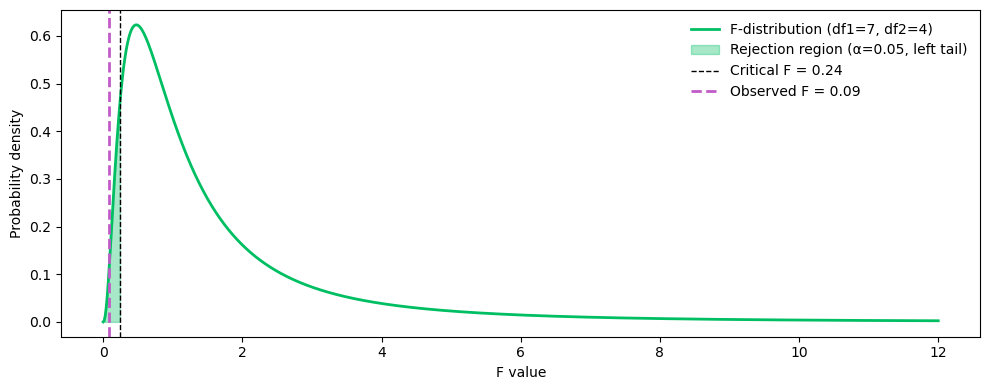

In [161]:
plot_f_test(f_statistic, (len(repeated_measurements.me.dropna()) - 1), (len(repeated_measurements.friend.dropna()) - 1), alpha=0.05, alternative='less')

> <font color='#fc7202'>**Additional: Levene’s Test for Equality of Variances**</font>
>
> As an alternative to the classical *F*-test, we can use **Levene’s test**, which is **more robust to non-normal data** and is commonly used today (especially in the Python scientific community).
>
> Levene’s test checks the same null hypothesis ($H_0$: the population variances are equal) but relies on the **absolute deviations from the median (or mean)** instead of assuming normality.This makes it much less sensitive to outliers or skewed distributions.
>
> We can easily perform Levene’s test in Python using `scipy.stats.levene()`. (https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.levene.html)


In [248]:
levene(repeated_measurements.me, repeated_measurements.friend, center='mean', nan_policy='omit')

LeveneResult(statistic=np.float64(13.039334683414797), pvalue=np.float64(0.004090369453050552))

## Part 2: The *F*-Test

The *F*-test is a statistical test used to **compare variances** - that is, to check whether two samples have **similar levels of variability** (a property called *homoscedasticity*).\
In practice, we often apply the *F*-test **before** performing a *t*-test to compare means, because the standard *t*-test assumes that both populations have **equal variances**.

By running an *F*-test first, we can verify this assumption:
- If the variances are **not significantly different**, we can safely use the **standard two-sample *t*-test** that assumes equal variances.  
- If the variances **do differ significantly**, we should instead use the **Welch’s *t*-test**, which does *not* assume equality of variances.

> **Equal-variance (pooled) *t*-test**\
> When the two samples have equal variances, the *t*-statistic is calculated as: $t = \frac{\bar{X}_1 - \bar{X}_2}{s_p \sqrt{\frac{1}{n_1} + \frac{1}{n_2}}}$, where
> - $s_p = \sqrt{\frac{(n_1 - 1)s_1^2 + (n_2 - 1)s_2^2}{n_1 + n_2 - 2}}$ is the **pooled standard deviation**, and 
> - $n_1, n_2, s_1, s_2$ are the sample sizes and sample standard deviations of the two groups.
>
> **Welch’s *t*-test (unequal variances)**\
> If the *F*-test suggests that the variances are unequal, we switch to **Welch’s *t*-test**, which does *not* assume variance equality.  
> The *t*-statistic is calculated as: $t = \frac{\bar{X}_1 - \bar{X}_2}{\sqrt{\frac{s_1^2}{n_1} + \frac{s_2^2}{n_2}}}$\
> The **degrees of freedom** for this test are *not* simply $n_1 + n_2 - 2$, but instead are **approximated using the Welch–Satterthwaite equation**:
> $\nu = \frac{\left( \frac{s_1^2}{n_1} + \frac{s_2^2}{n_2} \right)^2}{\frac{(s_1^2 / n_1)^2}{n_1 - 1} + \frac{(s_2^2 / n_2)^2}{n_2 - 1}}$\
> This formula provides an adjusted degree of freedom that accounts for unequal variances and unequal sample sizes.  
> It makes the Welch test more **robust** and accurate under heteroscedasticity (unequal variances).\
> *(See also: Welch, B. L. (1947). “The generalization of ‘Student’s’ problem when several different population variances are involved.” Biometrika 34(1–2): 28–35. https://doi.org/10.2307/2332510)*


**From Variance to the *F*-Distribution**\
To understand where the *F*-test originates, it helps to recall how the **sample variance** behaves from a statistical point of view.\
When we draw a sample from a **normally distributed population**, each observation can be seen as a random variable fluctuating around the true mean.\
If we measure how far each observation is from the mean, square those deviations, and then **sum them up**, the result (after appropriate standardization)\
follows a **chi-squared (χ²) distribution**. $\frac{(n - 1)s^2}{\sigma^2} \sim \chi^2_{(n - 1)}$, where:  
- $n$ is the sample size,  
- $s^2$ is the sample variance, and  
- $\sigma^2$ is the true population variance.

If two random variables $U$ and $V$ each follow a **chi-squared distributions** with degrees of freedom $\text{df}_U = \nu_1$ and $\text{df}_V = \nu_2$, respectively\
then the ratio $F = \frac{(U / \nu_1)}{(V / \nu_2)}$ follows an ***F*-distribution** with $\nu_1$ and $\nu_2$ degrees of freedom: $F \sim F_{(\nu_1, \nu_2)}$

Since the **sample variance** $s^2$ from a normally distributed population is related to a chi-squared variable by $\frac{(n - 1)s^2}{\sigma^2} \sim \chi^2_{(n - 1)}$, it follows that the **ratio of two independent sample variances**, each divided by its corresponding degrees of freedom, also follows an *F*-distribution: $F = \frac{(s_1^2 / \sigma_1^2) / (n_1 - 1)}{(s_2^2 / \sigma_2^2) / (n_2 - 1)}\sim F_{(n_1 - 1,\, n_2 - 1)}$.

The *F*-distribution is **right-skewed** and only takes **positive values**, since variances cannot be negative.  
It describes how the **ratio of two sample variances** behaves when both populations truly have equal variances.

> The *F*-distribution is named after the statistician Sir Ronald A. Fisher, who introduced it in the 1920s.\
> It was later popularized and formally named in his honor by George W. Snedecor.

**Using the *F*-Test**\
The *F*-test uses this *F*-distribution to determine whether the **observed ratio of sample variances** is unusually large or small.  
We compare the calculated *F*-value to a critical value that depends on:
- the **degrees of freedom** of both samples, and  
- the **significance level** (α), typically 0.05 or 0.01.

If the observed *F*-ratio exceeds the critical value, we reject $H_0$ and conclude that the variances differ significantly.

**Alternatives to the *F*-Test for Comparing Variances**\
While the classical *F*-test works well when data are **normally distributed**, it is **sensitive to non-normality**.  
For more robust comparisons of variances, consider these alternatives:

- **Levene’s test** - less sensitive to deviations from normality (recommended in most practical cases).  
  → [`scipy.stats.levene()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.levene.html)    
- **Bartlett’s test** - powerful under perfect normality but highly sensitive to outliers or skewed data.  
  → [`scipy.stats.bartlett()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.bartlett.html)


In [242]:
# Sliders
df1_slider = widgets.IntSlider(min=1, max=60, step=1, value=5, description='df₁ (num)')
df2_slider = widgets.IntSlider(min=1, max=60, step=1, value=5, description='df₂ (den)')

# X grid
x = np.linspace(0, 5, 800)
y = f.pdf(x, df1_slider.value, df2_slider.value)

# Define color for the curve
curve_color = '#00bf63' 

# Create the FigureWidget with white background
fig = go.FigureWidget(
    data=[go.Scatter(x=x, y=y, mode='lines', line=dict(color=curve_color, width=3))],
    layout=go.Layout(
        title=f'F-distribution (df₁ = {df1_slider.value}, df₂ = {df2_slider.value})',
        xaxis_title='F value',
        yaxis_title='Probability density',
        margin=dict(l=40, r=10, t=40, b=40),
        height=320,
        width=500,  
        paper_bgcolor='white',   
        plot_bgcolor='white'     
    )
)

# Update callback
def redraw(_=None):
    y_new = f.pdf(x, df1_slider.value, df2_slider.value)
    with fig.batch_update():
        fig.data[0].y = y_new
        fig.layout.title = f'F-distribution (df₁ = {df1_slider.value}, df₂ = {df2_slider.value})'

# Clean old observers if rerun
df1_slider.unobserve_all()
df2_slider.unobserve_all()
df1_slider.observe(redraw, names='value')
df2_slider.observe(redraw, names='value')

# Combine into compact UI
ui = VBox([HBox([df1_slider, df2_slider], layout=Layout(gap='12px')), fig])
display(ui)


#### <font color="#fc7202">Task 2:</font>

<div style="display: flex; align-items: center; justify-content: space-between;">

<div style="flex: 1;">
Since the year 812 CE, people in Japan have recorded the first day of the year when cherry trees reached full bloom in the city of Kyoto.
This remarkable dataset provides one of the world’s longest continuous records of local climate effects.

You can view an interactive time-series plot of the data here: [Kyoto Full Flowering Day Data (812–2025)](https://ourworldindata.org/grapher/date-of-the-peak-cherry-tree-blossom-in-kyoto)

1. Load the dataset into Python.\
   We will focus on the variable “Full Flowering Date (DOY)”, which represents the day of the year when cherry blossoms reached full bloom in Kyoto.
2. Explore the data visually.\
   Inspect the full time series of bloom dates and describe any long-term trends or patterns you notice.
3. Statistical analysis.\
   Using an appropriate version of the *t*-test, test whether the mean flowering day after 1880 is significantly earlier than before 1880 at the 95% confidence level.
</div>

<div style="flex: 0 0 400px; margin-left: 30px;">
<img src="https://raw.githubusercontent.com/RaHub4AI/MI7032/refs/heads/main/Pictures/cherry_blossoms.png"
     alt="Curious cow"
     width="300"
     style="border-radius: 10px;">
</div>

</div>

In [ ]:
# YOUR CODE HERE!

In [249]:
# Loading the dataset
kyoto_df = pd.read_csv(r'date-of-the-peak-cherry-tree-blossom-in-kyoto\date-of-the-peak-cherry-tree-blossom-in-kyoto.csv')
kyoto_df.head()

,Entity,Code,Year,Twenty-year average day of the year with peak cherry blossom,Day of the year with peak cherry blossom
0,Japan,JPN,853,101.000000,104
1,Japan,JPN,864,100.833336,100
2,Japan,JPN,866,101.571430,106
3,Japan,JPN,869,100.750000,95
4,Japan,JPN,889,101.111115,104


> When we inspect the columns, we notice that some have **very long names**, so let's simplify them and make the dataset easier to read and use.

In [210]:
# Displaying column names for reference
kyoto_df.columns

Index(['Entity', 'Code', 'Year',
       'Twenty-year average day of the year with peak cherry blossom',
       'Day of the year with peak cherry blossom'],
      dtype='object')

In [252]:
# Renaming the columns and sorting data chronologically
kyoto_df.rename(columns={'Twenty-year average day of the year with peak cherry blossom': 'average20',
                         'Day of the year with peak cherry blossom': 'doy'}, inplace=True)
kyoto_df = kyoto_df.sort_values(by='Year').reset_index(drop=True)

# Displaying dataset information and summary statistics
display(kyoto_df.info())
display(kyoto_df.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 837 entries, 0 to 836
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Entity     837 non-null    object 
 1   Code       837 non-null    object 
 2   Year       837 non-null    int64  
 3   average20  833 non-null    float64
 4   doy        837 non-null    int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 32.8+ KB


None

,Year,average20,doy
count,837.000000,833.000000,837.000000
mean,1554.476703,104.509370,104.389486
std,306.642906,2.805704,6.533776
min,812.000000,93.950000,84.000000
25%,1330.000000,103.150000,100.000000
50%,1588.000000,104.850000,104.000000
75%,1811.000000,106.200000,109.000000
max,2025.000000,110.950000,124.000000


> Let’s visualize how the **full flowering date (day of year)** has changed over time.  
> I aimed to create a plot that looks as similar as possible to the one shown on [Our World in Data](https://ourworldindata.org/grapher/date-of-the-peak-cherry-tree-blossom-in-kyoto)

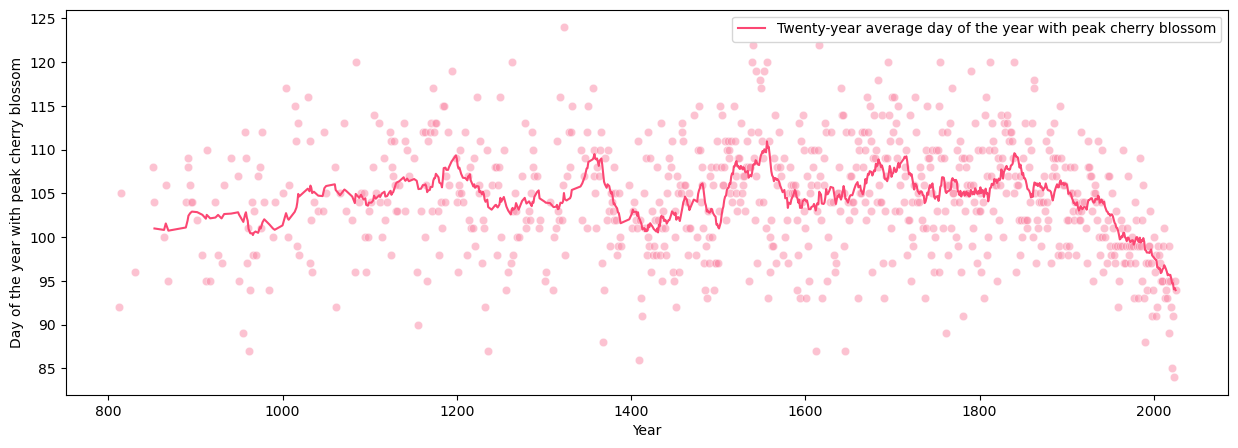

In [198]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.scatterplot(data=kyoto_df, x='Year', y='doy', ax=ax, color='#fa87a5', alpha=0.5)
sns.lineplot(data=kyoto_df, x='Year', y='average20', ax=ax, color='#fb4773', label='Twenty-year average day of the year with peak cherry blossom')
plt.xlabel('Year')
plt.ylabel('Day of the year with peak cherry blossom')
plt.show()


> Based on this plot, we can see that **between roughly 1800 and 1900**, the flowering dates in Kyoto started to shift **earlier and earlier** in the year.  
>
> Before that period, the **day of year (DOY)** for full bloom fluctuated around a fairly stable long-term average, but since the late 19th century the trend has become more pronounced - with blossoms appearing significantly earlier in modern times.  
>
> Next, our task is to **investigate this pattern statistically** and test whether the **mean flowering day after 1880** is indeed **significantly earlier** than before 1880.


**Hypotheses**

We want to test whether the **mean flowering day after 1880** is **significantly earlier** than before 1880.
- **Null hypothesis ($H_0$):**  
  The mean day of full bloom is the same before and after 1880:\
  <font color='#00bf63'>*$H_0: \mu_{\text{before}} = \mu_{\text{after}}$*</font>

- **Alternative hypothesis ($H_1$):**  
  The mean day of full bloom **after 1880** is **earlier** (smaller day-of-year value) than before 1880:\
  <font color='#00bf63'>*$H_1: \mu_{\text{after}} < \mu_{\text{before}}$*</font> 

This is therefore a **one-tailed (left-tailed) two-sample *t*-test**, testing whether the mean flowering day after 1880 is significantly earlier than before 1880.

> *To test whether the average flowering day **after 1880** is significantly earlier than **before 1880**, we can divide our dataset into two groups.*
>
> *One option is to create two separate DataFrames - one for years before 1880, and one for years after (and including) 1880:*

In [255]:
# Splitting the dataset into two time periods
before_1880 = kyoto_df[kyoto_df.Year < 1880].reset_index(drop=True)
after_1880 = kyoto_df[kyoto_df.Year >= 1880].reset_index(drop=True)
display(before_1880.tail())
display(after_1880.head())

,Entity,Code,Year,average20,doy
690,Japan,JPN,1875,105.65,103
691,Japan,JPN,1876,106.15,111
692,Japan,JPN,1877,105.80,104
693,Japan,JPN,1878,105.45,101
694,Japan,JPN,1879,105.35,102


,Entity,Code,Year,average20,doy
0,Japan,JPN,1880,105.35,110
1,Japan,JPN,1881,105.30,112
2,Japan,JPN,1882,105.15,97
3,Japan,JPN,1883,104.65,107
4,Japan,JPN,1884,104.20,109


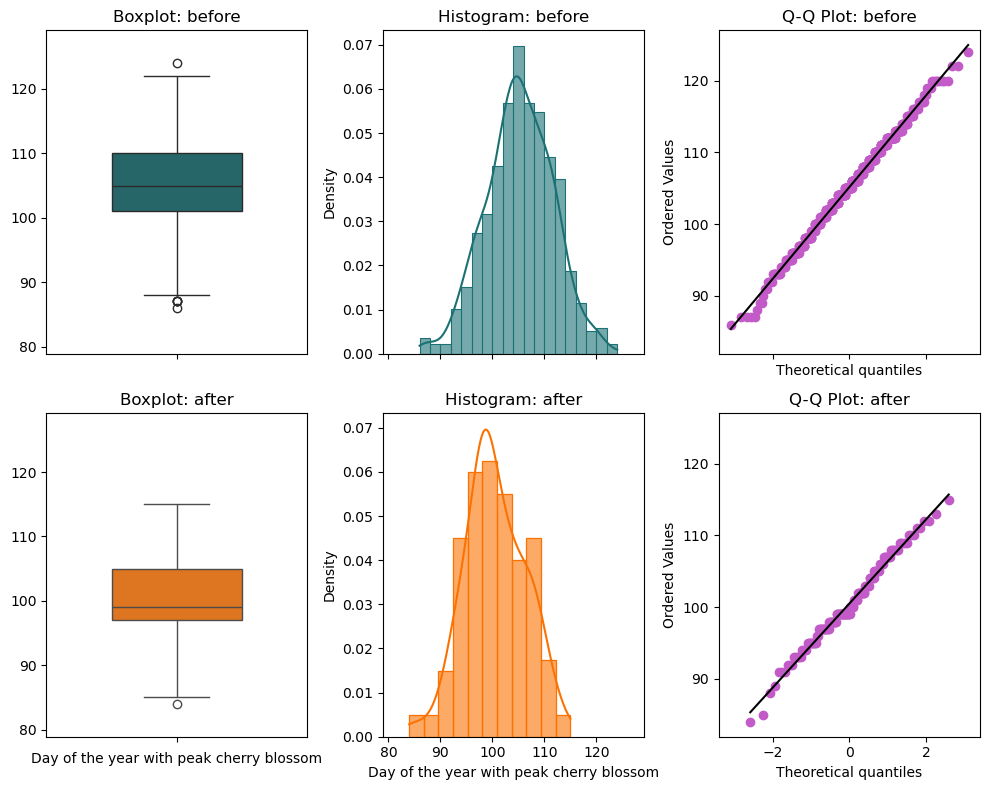

In [257]:
colors = ['#1b7173', '#fc7202']

# Set common axis limits for both samples to allow direct comparison
# For boxplots
y_min = min(before_1880.doy.min(), after_1880.doy.min()) - 5
y_max = max(before_1880.doy.max(), after_1880.doy.max()) + 5
# For histograms
x_min, x_max = y_min, y_max

fig, axes = plt.subplots(2, 3, figsize=(10, 8), sharex='col', sharey='col')

time_interval = ['before', 'after']

for i, interval in enumerate(time_interval):
    if interval == 'before':
        data = before_1880
    else:
        data = after_1880
    
    sns.boxplot(y=data.doy, color=colors[i], width=0.5, ax=axes[i, 0])
    axes[i, 0].set_ylim(y_min - 0.1, y_max + 0.1)
    axes[i, 0].set_title(f'Boxplot: {interval}')
    axes[i, 0].set_ylabel('')
    axes[i, 0].set_xlabel('Day of the year with peak cherry blossom')

    sns.histplot(data.doy, kde=True, color=colors[i], stat='density', alpha=0.6, edgecolor=colors[i], ax=axes[i, 1])
    axes[i, 1].set_xlim(x_min - 0.1, x_max + 0.1)
    axes[i, 1].set_title(f'Histogram: {interval}')
    axes[i, 1].set_ylabel('Density')
    axes[i, 1].set_xlabel('Day of the year with peak cherry blossom')

    # Q-Q Plot
    stats.probplot(data.doy, dist='norm', plot=axes[i, 2])
    axes[i, 2].get_lines()[0].set_markerfacecolor('#c25bc7')
    axes[i, 2].get_lines()[0].set_markeredgecolor('#c25bc7')
    axes[i, 2].get_lines()[1].set_color('black')
    axes[i, 2].set_title(f'Q-Q Plot: {interval}')

plt.tight_layout()
plt.show()

In [258]:
before_1880.describe()

,Year,average20,doy
count,695.000000,691.000000,695.000000
mean,1472.966906,105.167953,105.178417
std,271.451845,2.132544,6.390045
min,812.000000,100.250000,86.000000
25%,1264.500000,103.800000,101.000000
50%,1511.000000,105.200000,105.000000
75%,1700.500000,106.650000,110.000000
max,1879.000000,110.950000,124.000000


In [259]:
after_1880.describe()

,Year,average20,doy
count,142.000000,142.000000,142.000000
mean,1953.415493,101.304577,100.528169
std,42.421098,3.424354,5.835443
min,1880.000000,93.950000,84.000000
25%,1916.250000,98.737500,97.000000
50%,1954.500000,101.825000,99.000000
75%,1989.750000,104.250000,105.000000
max,2025.000000,106.500000,115.000000


> **Why use `density=True` for the histogram?**  
> The pre- and post-1880 groups have **different sample sizes**. If we plotted **counts**, the larger group would dominate the bars even if both groups had the same underlying shape. Using **density** (area under each histogram = 1) puts both groups on a **common scale**, so we’re comparing **distribution shapes** (location, spread, skew) rather than raw frequencies. This makes visual comparisons fair and interpretable.


> From the plots, the data from both groups (**before 1880** and **after 1880**) look **approximately normally distributed**.\
> To be rigorous, let’s also test normality with the **Shapiro-Wilk test** for each period.


In [264]:
# Checking the normality assumption using the Kolgomorov-Smirnov test
# Null hypothesis (H0): the data come from a normal distribution
from scipy.stats import kstest
ks_stat_before, ks_p_before = kstest(before_1880.doy, 'norm', args=(before_1880.doy.mean(), before_1880.doy.std(ddof=1)))
ks_stat_after, ks_p_after = kstest(after_1880.doy, 'norm', args=(after_1880.doy.mean(), after_1880.doy.std(ddof=1)))

print('Kolgomorov-Smirnov Test Results:')
print(f'Before 1880: test statistic: {ks_stat_before:.4f}, p-value: {ks_p_before:.4f}')
print(f'After 1880: test statistic: {ks_stat_after:.4f}, p-value: {ks_p_after:.4f}')

Kolgomorov-Smirnov Test Results:
Before 1880: test statistic: 0.0441, p-value: 0.1298
After 1880: test statistic: 0.1103, p-value: 0.0583


In [265]:
# Checking the normality assumption using the Shapiro-Wilk test
# Null hypothesis (H0): the data come from a normal distribution
sw_stat_before, sw_p_before = shapiro(before_1880.doy)
sw_stat_after, sw_p_after = shapiro(after_1880.doy)

print('Shapiro-Wilk Test Results:')
print(f'Before 1880: test statistic: {sw_stat_before:.4f}, p-value: {sw_p_before:.4f}')
print(f'After 1880: test statistic: {sw_stat_after:.4f}, p-value: {sw_p_after:.4f}')

Shapiro-Wilk Test Results:
Before 1880: test statistic: 0.9959, p-value: 0.0649
After 1880: test statistic: 0.9881, p-value: 0.2614


Both time periods yield *p*-values greater than 0.05 (before 1880: 0.0649 (Shapiro-Wilk)/0.1298 (Kolgomorov-Smirnov); after 1880: 0.2614 (Shapiro-Wilk)/0.0583 (Kolgomorv-Smirnov)).  
Therefore, we **fail to reject the null hypothesis** that the data in each group come from a normal distribution.  

In other words, both the pre-1880 and post-1880 flowering-date data are **approximately normally distributed**.  
This means we can confidently proceed with a **parametric *t*-test** to compare their mean flowering dates.

> *Note:* Visual diagnostics (histograms, Q-Q plots) and the Shapiro-Wilk test complement each other.  
> With large samples, Shapiro-Wilk can flag tiny deviations; Q-Q plots help judge **practical** normality for the *t*-test.


After confirming that both samples are **approximately normally distributed**, the next step is to check whether their **variances are equal**.\
This matters because the **standard two-sample *t*-test** assumes that both populations have the **same variance (homoscedasticity)**.  

> If this assumption holds, we can use the **regular (pooled-variance) two-sample *t*-test**.\
> However, if the variances differ significantly, we should instead use the **Welch’s *t*-test**, which does *not* assume equal variances and is more robust when sample sizes or variances are unequal.

We can check this assumption using an ***F*-test** (or a **Levene’s test**).

In [230]:
# Using our previously defined F-test
f_statistic, p_value = f_test(before_1880.doy, after_1880.doy, alternative='two-sided')
print(f'F-statistic: {f_statistic:.4f}, p-value: {p_value:.4f}')

F-statistic: 1.1991, p-value: 0.1828


> The *p*-value (0.1828) is greater than 0.05, so we **fail to reject the null hypothesis** that the variances are equal.  
> This suggests that the two groups have **similar variability** in flowering dates.
>
> *To confirm, we can use the **Levene’s test**, which is more robust to non-normality:*

In [234]:
levene_stat, levene_p_value = levene(before_1880.doy, after_1880.doy, center='median')
print(f"Levene’s test statistic: {levene_stat:.4f}, p-value: {levene_p_value:.4f}")

Levene’s test statistic: 1.3611, p-value: 0.2437


> The Levene’s test result (*p*-value = 0.2437) leads to the same conclusion - there is **no significant difference in variances** between the two periods.

Therefore, we can proceed with the **standard two-sample (pooled) *t*-test** (one-tailed) under the assumption of **equal variances**.

In [238]:
t_statistic_one_tailed, p_value_one_tailed = ttest_ind(after_1880.doy, before_1880.doy, equal_var=True, alternative='less')
print(f't-statistic: {t_statistic_one_tailed:.4f}, p-value: {p_value_one_tailed:.4f}')

t-statistic: -8.0153, p-value: 0.0000


> Since the *p*-value is far below our significance level (*α* = 0.05), **we reject $H_0$**.
> There is strong statistical evidence that the mean full-flowering day after 1880 occurs earlier (i.e., has a smaller day-of-year value) than before 1880.

<font color="#fc7202">**Important note on one-tailed tests**</font>

In **one-tailed** tests, the **order of the samples matters** because it sets the *direction* of the hypothesis being tested.
- With `alternative='less'`, SciPy tests whether the **first sample’s mean < second sample’s mean**.
- In our test we intentionally used `after_1880` **first** and `before_1880` **second** to test $\mu_{\text{after}} < \mu_{\text{before}}$.

If you **swap** the sample order while keeping `alternative='less'`, you would instead test $\mu_{\text{before}} < \mu_{\text{after}}$,\
which is the **opposite** of our research question and would lead to a misleadingly **large *p*-value**.


In [240]:
# Wrong direction (swapped order):
t_stat_swapped, p_val_swapped = ttest_ind(before_1880.doy, after_1880.doy, equal_var=True, alternative='less')
print(f'Swapped order → t = {t_stat_swapped:.4f}, p = {p_val_swapped:.4f}')

Swapped order → t = 8.0153, p = 1.0000
